<a href="https://colab.research.google.com/github/seenu-g/eva4-2/blob/master/week13/Speech_to_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf ./*
!wget -O speech_commands_v0.01.tar.gz http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
!tar xzf speech_commands_v0.01.tar.gz 
!ls

--2020-11-23 06:17:24--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.9.208, 2607:f8b0:4004:806::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.9.208|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   237MB/s    in 6.0s    

2020-11-23 06:17:30 (236 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

_background_noise_  go	     on				   testing_list.txt
bed		    happy    one			   three
bird		    house    README.md			   tree
cat		    left     right			   two
dog		    LICENSE  seven			   up
down		    marvin   sheila			   validation_list.txt
eight		    nine     six			   wow
five		    no	     speech_commands_v0.01.tar.gz  yes
four		    off      stop			   zero


In [2]:
!pip install torchaudio

     |████████████████████████████████| 7.6MB 11.2MB/s 


In [3]:
from IPython.display import Audio

## PyTorch things
import torch
import torchaudio
import torch.nn.functional as F

## Other libs
import matplotlib.pyplot as plt
import glob
import os
import random
from tqdm import tqdm_notebook
import torchsummary
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import pandas as pd
import seaborn as sn

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [4]:
classes = os.listdir()
classes.remove("LICENSE")
classes.remove("README.md")
classes.remove("_background_noise_")
classes.remove("speech_commands_v0.01.tar.gz")
classes.remove("testing_list.txt")
classes.remove("validation_list.txt")
classes.remove(".config")
print(classes)
print("Number of classes", len(classes))

['six', 'nine', 'on', 'left', 'three', 'five', 'go', 'bird', 'seven', 'off', 'wow', 'two', 'stop', 'zero', 'up', 'house', 'happy', 'cat', 'sheila', 'down', 'right', 'four', 'one', 'tree', 'eight', 'bed', 'marvin', 'dog', 'yes', 'no']
Number of classes 30


Using the **Audio(filename)** function from IPython notebook, you can listen to an audio file directly in Colab.

In [5]:
Audio("bed/1528225c_nohash_2.wav")

In [6]:
Audio("cat/004ae714_nohash_0.wav")


Use **torchaudio.load** to load an audio file. Then, use matplotlib to display 

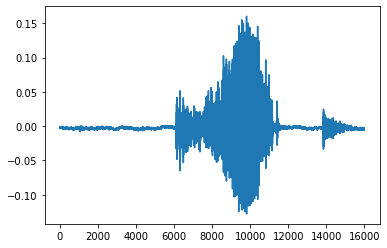

In [10]:
waveform, sample_rate = torchaudio.load("cat/004ae714_nohash_0.wav", normalization=True)
#transpose the waveform with .t() in order to display it
plt.plot(waveform.t())

MFCC (Mel Frequency Cepstral Coefficients) features is a well known signal processing technique, used in ASR (Automatic Speech Recognition), are meant to represent the way humans perceive sound. https://en.wikipedia.org/wiki/Mel-frequency_cepstrum Torchaudio has transforms (just like the ones in torchvision) that allow you to compute these features:

torch.Size([1, 12, 81])


/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


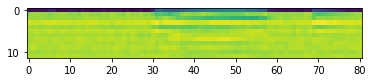

In [12]:
# we are only keeping 12 MFCC features 
mfcc = torchaudio.transforms.MFCC(n_mfcc=12, log_mels=True)(waveform)
plt.figure()
plt.imshow(mfcc[0].detach().numpy())
print(mfcc.shape)
#get Tensor of shape [1, 12, 81], because we have one audio channel (mono) with 12 coefficients over 81 time windows.

## Creating a custom audio Dataset

In [13]:
## Read the test list
with open("testing_list.txt") as testing_f:
  testing_list = [x.strip() for x in testing_f.readlines()]

## Read the val list
with open("validation_list.txt") as val_f:
  validation_list = [x.strip() for x in val_f.readlines()]  

print("Number of testing samples", len(testing_list))
print("Number of validation samples", len(validation_list))

## Construct a train list
training_list = []
for c in classes:
  training_list += glob.glob(c + "/*")

training_list = list(filter(lambda x : not x in testing_list and not x in validation_list, training_list))
print("Number of training samples", len(training_list))

Number of testing samples 6835
Number of validation samples 6798
Number of training samples 51088


Here is custom SpeechDataset class that takes a file list in input.

In [14]:
class SpeechDataset(torch.utils.data.Dataset):
  
  def __init__(self, classes, file_list):
    
    self.classes = classes
    
    # create a map from class name to integer
    self.class_to_int = dict(zip(classes, range(len(classes))))
    
    # store the file names
    self.samples = file_list
    
    # store our MFCC transform
    self.mfcc_transform = torchaudio.transforms.MFCC(n_mfcc=12, log_mels=True)
    
  def __len__(self):
    return len(self.samples)
    
  def __getitem__(self,i):
    with torch.no_grad():
      # load a normalized waveform
      waveform,_ = torchaudio.load(self.samples[i], normalization=True)
      
      # if the waveform is too short (less than 1 second) we pad it with zeroes
      if waveform.shape[1] < 16000:
        waveform = F.pad(input=waveform, pad=(0, 16000 - waveform.shape[1]), mode='constant', value=0)
      
      # then, we apply the transform
      #mfcc = self.mfcc_transform(waveform).squeeze(0).transpose(0,1)
    
    # get the label from the file name
    label = self.samples[i].split("/")[0]
    
    # return the mfcc coefficient with the sample label
    return waveform.t(), self.class_to_int[label]

In [15]:
#Create your Dataset objects for training.
train_set = SpeechDataset(classes, training_list)
val_set =SpeechDataset(classes, validation_list)

print(train_set[5][0].shape)

torch.Size([16000, 1])


/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [16]:
# Create DataLoaders with the Datasets, add shuffling to the training DataLoader.
train_dl = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=16)

print(next(iter(train_dl)))

[tensor([[[ 6.1035e-05],
         [ 9.1553e-05],
         [-3.0518e-05],
         ...,
         [ 6.1035e-05],
         [ 6.1035e-05],
         [ 6.1035e-05]],

        [[ 3.0518e-05],
         [ 4.2725e-04],
         [ 4.5776e-04],
         ...,
         [-5.7983e-04],
         [-2.1362e-04],
         [-4.5776e-04]],

        [[ 3.0518e-05],
         [-1.2207e-03],
         [-4.2725e-04],
         ...,
         [-2.3804e-03],
         [-1.5564e-03],
         [-1.7090e-03]],

        ...,

        [[ 9.1553e-05],
         [ 3.6621e-04],
         [ 6.4087e-04],
         ...,
         [-8.8501e-04],
         [-6.4087e-04],
         [-4.2725e-04]],

        [[ 2.1973e-03],
         [ 3.4485e-03],
         [ 2.7161e-03],
         ...,
         [-9.0332e-03],
         [-9.8877e-03],
         [-3.3569e-03]],

        [[ 6.1340e-03],
         [ 1.2878e-02],
         [ 1.2726e-02],
         ...,
         [ 1.8921e-03],
         [ 7.9346e-03],
         [ 8.6365e-03]]]), tensor([12, 12,  2, 14, 

## Implement the network
For our network, we are going to use an **RNN module** from torch.nn (which can have multiple layers, or cells). This module has an **input size**, which in our case will be equal to **the number of MFCC features (12)**. The input size is the number of dimensions of **x** in the image below.

In [17]:
class SpeechRNN(torch.nn.Module):
  
  def __init__(self):
    super(SpeechRNN, self).__init__()
    
    self.lstm = torch.nn.GRU(input_size = 1, 
                              hidden_size= 256, 
                              num_layers = 2, 
                              batch_first=True)
    
    self.out_layer = torch.nn.Linear(256, 30)
    
    self.softmax = torch.nn.LogSoftmax(dim=1)
    
  def forward(self, x):
    
    out, _ = self.lstm(x)
    
    x = self.out_layer(out[:,-1,:])
    
    return self.softmax(x)

In [18]:
net = SpeechRNN().cuda()
batch = next(iter(train_dl))[0]
print(batch.shape)
y = net(batch.cuda())

print(y.shape)

torch.Size([16, 16000, 1])
torch.Size([16, 30])


In [21]:
# define a loss and an optimizer. As we have a categorical classification problem, we use cross-entropy (negative log likelihood).

LEARNING_RATE = 0.001
net = SpeechRNN()
net = net.cuda()
# Negative log likelihood loss
criterion = torch.nn.NLLLoss()
# Adam optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

Train

In [22]:
## NUMBER OF EPOCHS TO TRAIN
N_EPOCHS = 5

epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []

for e in range(N_EPOCHS):
  
  print("EPOCH:",e)
  
  ### TRAINING LOOP
  running_loss = 0
  running_accuracy = 0
  
  ## Put the network in training mode
  net.train()
  
  for i, batch in enumerate(tqdm_notebook(train_dl)):
    
    # Get a batch from the dataloader
    x = batch[0]
    labels = batch[1]
    
    # move the batch to GPU
    x = x.cuda()
    labels = labels.cuda()

    # Compute the network output
    y = net(x)
    
    # Compute the loss
    loss = criterion(y, labels)
    
    # Reset the gradients
    optimizer.zero_grad()
    
    # Compute the gradients
    loss.backward()
    
    # Apply one step of the descent algorithm to update the weights
    optimizer.step()
    
    ## Compute some statistics
    with torch.no_grad():
      running_loss += loss.item()
      running_accuracy += (y.max(1)[1] == labels).sum().item()
    
  print("Training accuracy:", running_accuracy/float(len(train_set)),
        "Training loss:", running_loss/float(len(train_set)))
  
  epoch_loss.append(running_loss/len(train_set))
  epoch_acc.append(running_accuracy/len(train_set))
  
  ### VALIDATION LOOP
  ## Put the network in validation mode
  net.eval()
  
  running_val_loss = 0
  running_val_accuracy = 0
  
  for i, batch in enumerate(val_dl):
    
    with torch.no_grad():
      # Get a batch from the dataloader
      x = batch[0]
      labels = batch[1]

      # move the batch to GPU
      x = x.cuda()
      labels = labels.cuda()

      # Compute the network output
      y= net(x)
      
      # Compute the loss
      loss = criterion(y, labels)
      
      running_val_loss += loss.item()
      running_val_accuracy += (y.max(1)[1] == labels).sum().item()
    
  print("Validation accuracy:", running_val_accuracy/float(len(val_set)),
        "Validation loss:", running_val_loss/float(len(val_set)))
  
  epoch_val_loss.append(running_val_loss/len(val_set))
  epoch_val_acc.append(running_val_accuracy/len(val_set))

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training accuracy: 0.0350963044159098 Training loss: 0.21223524805990238
Validation accuracy: 0.03662842012356576 Validation loss: 0.21198333996679897
EPOCH: 1



Training accuracy: 0.037112433448167864 Training loss: nan
Validation accuracy: 0.038540747278611356 Validation loss: nan
EPOCH: 2



Training accuracy: 0.03646648919511431 Training loss: nan
Validation accuracy: 0.038540747278611356 Validation loss: nan
EPOCH: 3



Training accuracy: 0.03646648919511431 Training loss: nan
Validation accuracy: 0.038540747278611356 Validation loss: nan
EPOCH: 4



Training accuracy: 0.03646648919511431 Training loss: nan
Validation accuracy: 0.038540747278611356 Validation loss: nan


In [23]:
# we need to evaluate our network on the test set.
# Create a test dataset instance
test_dataset = SpeechDataset(classes, testing_list)

# Create a DataLoader
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=64)

net.eval()

test_loss = 0
test_accuracy = 0

preds, y_test = np.array([]), np.array([])

for i, batch in enumerate(test_dl):

  with torch.no_grad():
    # Get a batch from the dataloader
    x = batch[0]
    labels = batch[1]

    # move the batch to GPU
    x = x.cuda()
    labels = labels.cuda()

    # Compute the network output
    y = net(x)

    # Compute the loss
    loss = criterion(y, labels)
    
    ## Store all the predictions an labels for later
    preds = np.hstack([preds, y.max(1)[1].cpu().numpy()])
    y_test = np.hstack([y_test, labels.cpu().numpy()])

    test_loss += loss.item()
    test_accuracy += (y.max(1)[1] == labels).sum().item()

print("Test accuracy:", test_accuracy/float(len(test_dataset)),
      "Test loss:", test_loss/float(len(test_dataset)))

/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


Test accuracy: 0.035698610095098754 Test loss: nan


In classification problems, it is common to use a confusion matrix to visualize which particular classes the model struggles with. What is the confusion that your network makes the most?

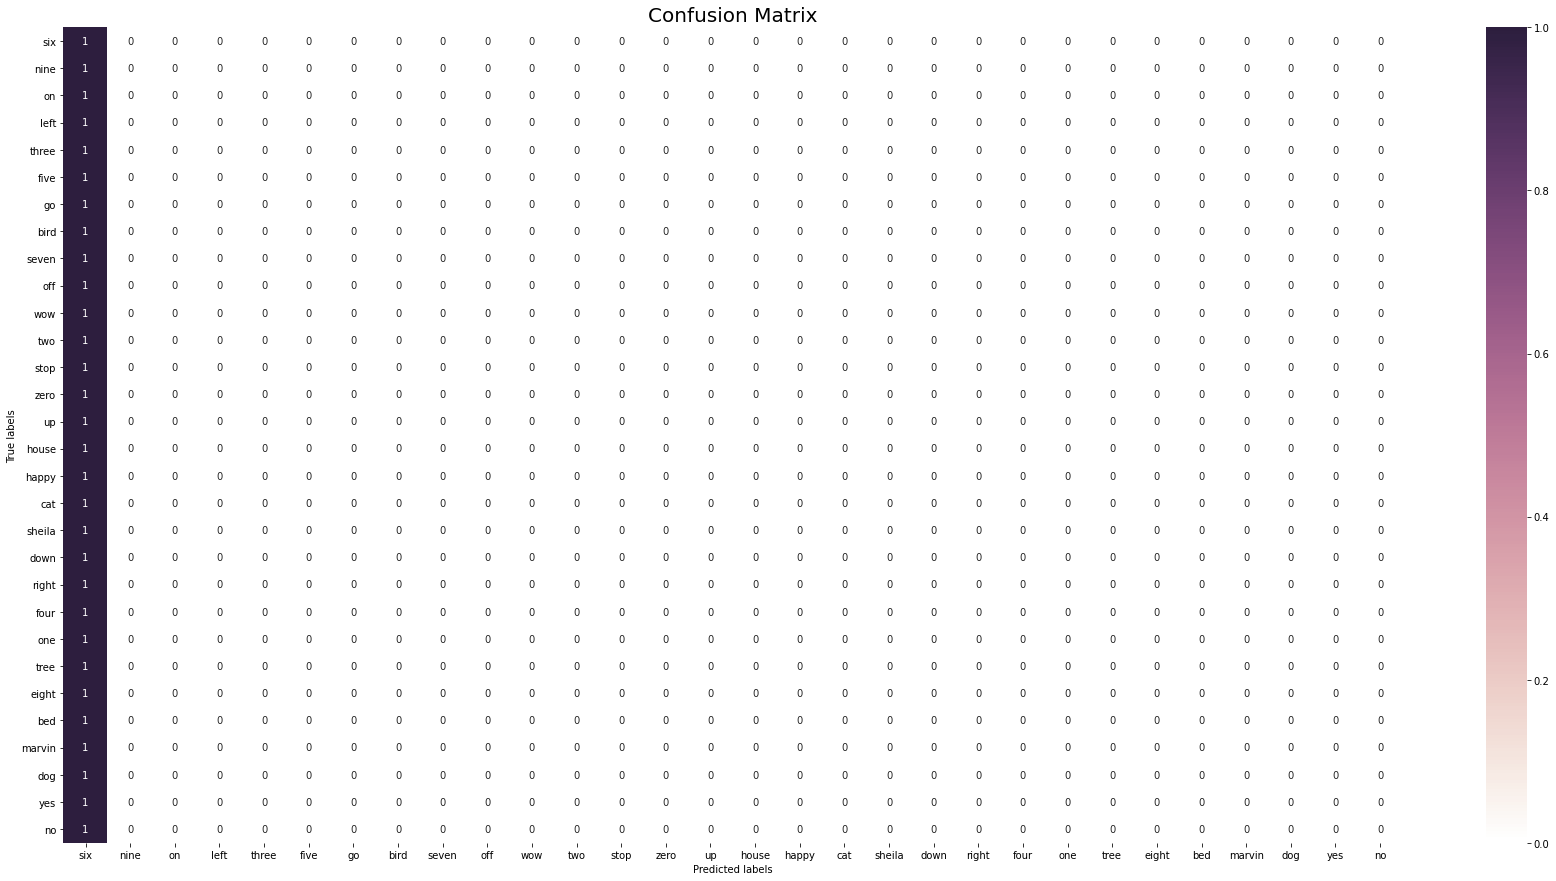

In [24]:
def show_confusion_matrix(pred, Y_TEST, classes):

  cm = confusion_matrix(y_true=Y_TEST, y_pred=pred)
  cm = normalize(cm,axis=1,norm='l1')
  
  df_cm = pd.DataFrame(cm, index = classes, columns = classes)
  
  plt.figure(figsize=(30,15))
  
  cmap = sn.cubehelix_palette(light=1, as_cmap=True)
  sn.heatmap(df_cm, annot=True,cmap=cmap)
  plt.title('Confusion Matrix',fontdict={'fontsize':20})
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show


show_confusion_matrix(preds, y_test, classes)